In [1]:
# import system modules
import sys
import os
os.system('for a in /sys/bus/pci/devices/*; do echo 0 | tee -a $a/numa_node>/dev/null; done') # get rid of NUMA node warnings in my docker: https://github.com/tensorflow/tensorflow/issues/42738
import gc

# import standard numerical modules
import numpy as np
import math

# import machine learning modules
import tensorflow as tf
import keras.backend as K

gpu = tf.config.list_physical_devices('GPU') # make sure GPU usage is enabled
print(gpu)

sys.path.append('../')
import DCTR


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# load data

In [2]:
# directory with pre converted lhe files as numpy arrays
data_dir = '../../Data' # modify as needed


In [3]:
# Load POWHEG hvq x0 datasets
# x0_nrm for training, x0_plt and x0_plt_nrm for calculating stats used to decide which model performs best
# only contain tt-pair; every event has order: 
    # tt-pair, top, anti-top
# every particle has arguments: 
    # [pt, y, phi, mass, eta, E, PID, w, theta]
    # [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
x0_nrm = []
x0_nrm = np.load(f'{data_dir}/POWHEG_hvq/showered/normed_lhe_01.npy')[:9543943] # 9543943 num of NNLO samples
print(f'POWHEG hvq x0_nrm.shape:     {x0_nrm.shape}')

# plotting data; different from training data; for calculating stats
x0_plt = []
x0_plt = np.load(f'{data_dir}/POWHEG_hvq/showered/converted_lhe_02.npy')[:9543943]
print(f'POWHEG hvq x0_plt.shape:     {x0_plt.shape}')

x0_plt_nrm = []
x0_plt_nrm = np.load(f'{data_dir}/POWHEG_hvq/showered/normed_lhe_02.npy')[:9543943]
print(f'POWHEG hvq x0_plt_nrm.shape: {x0_plt_nrm.shape}')



POWHEG hvq x0_nrm.shape:     (9543943, 3, 9)
POWHEG hvq x0_plt.shape:     (9543943, 3, 9)
POWHEG hvq x0_plt_nrm.shape: (9543943, 3, 9)


In [4]:
# MiNNLO x1
# training data
x1_nrm = []
x1_nrm = np.load(f'{data_dir}/MiNNLO/showered/normed_lhe.npy')
print(f'MiNNLO all particles x1_nrm.shape: {x1_nrm.shape}')

# plotting data
x1_plt = []
x1_plt = np.load(f'{data_dir}/MiNNLO/showered/converted_lhe.npy')
print(f'MiNNLO all particles x1_plt.shape: {x1_plt.shape}')


MiNNLO all particles x1_nrm.shape: (9543943, 3, 9)
MiNNLO all particles x1_plt.shape: (9543943, 3, 9)


In [5]:
# get normalized event generator weights | all weigths = +/-1
x0_wgt = x0_nrm[:, 0, 7].copy()

x0_plt_wgt = x0_plt_nrm[:, 0, 7].copy() 

x1_wgt = x1_nrm[:, 0, 7].copy()


In [6]:
# check sum of wgt for both classes
print(f'x0 wgt sum: {np.sum(x0_wgt)}')
print(f'x1 wgt sum: {np.sum(x1_wgt)}')


x0 wgt sum: 9466735.0
x1 wgt sum: 7685031.0


In [7]:
# delete eta (pseudorapidity) and Energy -> Train only with [pt, y, phi, m, PID]

# delete energy
x0_nrm = np.delete(x0_nrm, 5, -1)
x0_plt_nrm = np.delete(x0_plt_nrm, 5, -1)
x1_nrm = np.delete(x1_nrm, 5, -1)

# delete eta
x0_nrm = np.delete(x0_nrm, 4, -1)
x0_plt_nrm = np.delete(x0_plt_nrm, 4, -1)
x1_nrm = np.delete(x1_nrm, 4, -1)


In [8]:
# prep arrays for training
x_train, x_val, y_train, y_val, wgt_train, wgt_val = DCTR.prep_arrays(x0_nrm, x1_nrm, val=0.25)


2024-06-18 09:40:50.007173: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 09:40:50.679311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3325 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5
2024-06-18 09:40:50.687730: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1717909800 exceeds 10% of free system memory.
2024-06-18 09:40:51.444380: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 229054640 exceeds 10% of free system memory.
2024-06-18 09:40:51.512347: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 572636520 e

In [8]:
K.clear_session() 
print(gc.collect()) # cpu gabage collection to free up memory from discarded temp arrays


0


# training loop

In [10]:
train_dir = './train_20240523_regular_epochs' # where to save models during training


In [11]:
# setup DCTR neural network
''' default setup_nn() args:
input_dim=5, Phi_sizes = (100,100,128), F_sizes = (100,100,100),
loss = 'cce', dropout=0.0, l2_reg=0.0, Phi_acts='relu', F_acts='relu', output_act='softmax',
learning_rate=0.001, patience=10, use_scheduler=True, monitor='val_loss', reduceLR = True,
mode='min', savePath=currentPath, saveLabel='DCTR_training', summary=False, verbose = 2
'''

dctr, callbacks = DCTR.setup_nn(saveLabel='train_20240523_regular_epochs', loss='mse', patience=30, learning_rate=0.001, use_scheduler=False)



Epoch 1/250

Epoch 1: val_loss improved from inf to 0.21748, saving model to /tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/train_20240523_regular_epochs.tf


2024-05-23 18:33:56.016013: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/train_20240523_regular_epochs.tf/assets
110/110 - 7s - loss: 0.2257 - acc: 0.5216 - val_loss: 0.2175 - val_acc: 0.5298 - lr: 0.0010 - 7s/epoch - 68ms/step
Epoch 2/250

Epoch 2: val_loss improved from 0.21748 to 0.21649, saving model to /tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/train_20240523_regular_epochs.tf
INFO:tensorflow:Assets written to: /tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/train_20240523_regular_epochs.tf/assets
110/110 - 6s - loss: 0.2169 - acc: 0.5306 - val_loss: 0.2165 - val_acc: 0.5319 - lr: 0.0010 - 6s/epoch - 53ms/step
Epoch 3/250

Epoch 3: val_loss improved from 0.21649 to 0.21583, saving model to /tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/train_20240523_regular_epochs.tf
INFO:tensorflow:Assets written to: /tf/home/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/tr

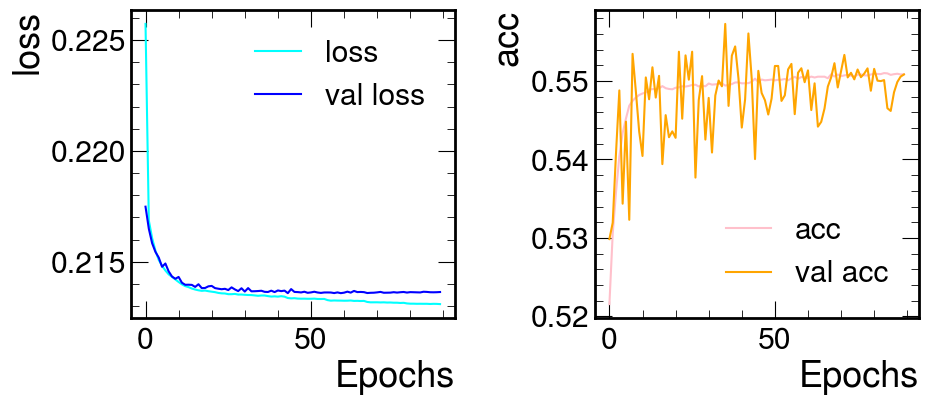

clearing keras session and collecting garbage


0.21308791637420654

In [13]:
# train DCTR neural network
''' train() necessary args:
dctr, callbacks, X_train, Y_train, X_val, Y_val
default args: 
wgt_train=1.0, wgt_val=1.0, epochs=80, batch_size=8192, savePath=currentPath, saveLabel='DCTR_training', verbose = 2, plot=True
'''

DCTR.train(dctr, callbacks, x_train, y_train, x_val, y_val, wgt_train=wgt_train, wgt_val=wgt_val, batch_size=8192*16, savePath = train_dir, saveLabel='train_20240523_regular_epochs', epochs=250)


# Plots

2024-06-19 08:04:20.162882: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 08:04:20.762886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6183 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


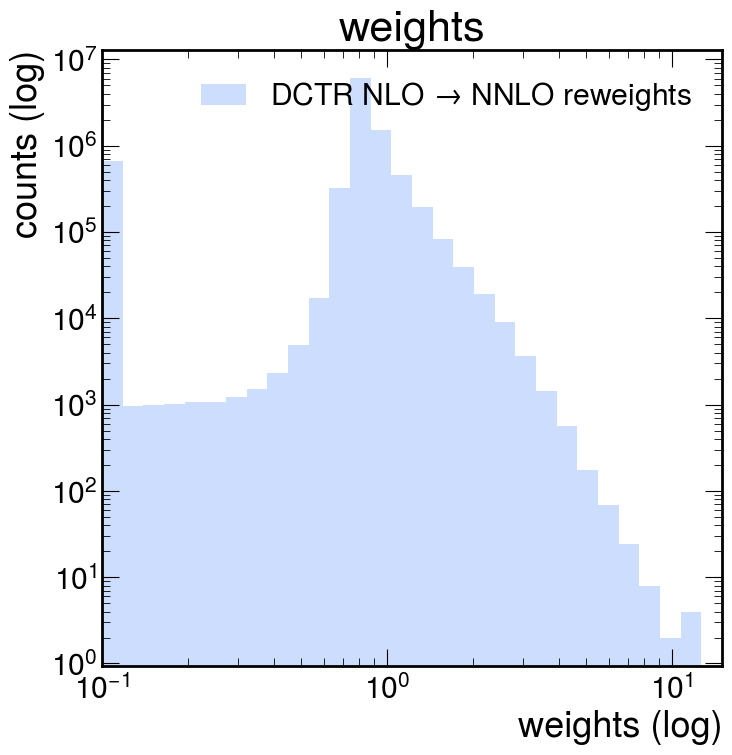

In [9]:
model = './train_20240523_regular_epochs.tf' # path to previously trained model (in .tf format (folder))

# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], x0_plt_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook
# plot and check dctr rwgt
wgts = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts, start = 0.1, stop = 15)

# print(dctr_rwgt[0])

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0], x0_plt_wgt)


In [10]:
x1_plt_wgt = x1_plt[:, 0, 7].copy()

# setup args for plotting
args = [(x1_plt, x1_plt_wgt, 'NNLO (MiNNLO)'),
        (x0_plt, x0_plt_wgt, 'NLO (hvq)'),
        (x0_plt, rwgt, 'Reweighted NNLO')]


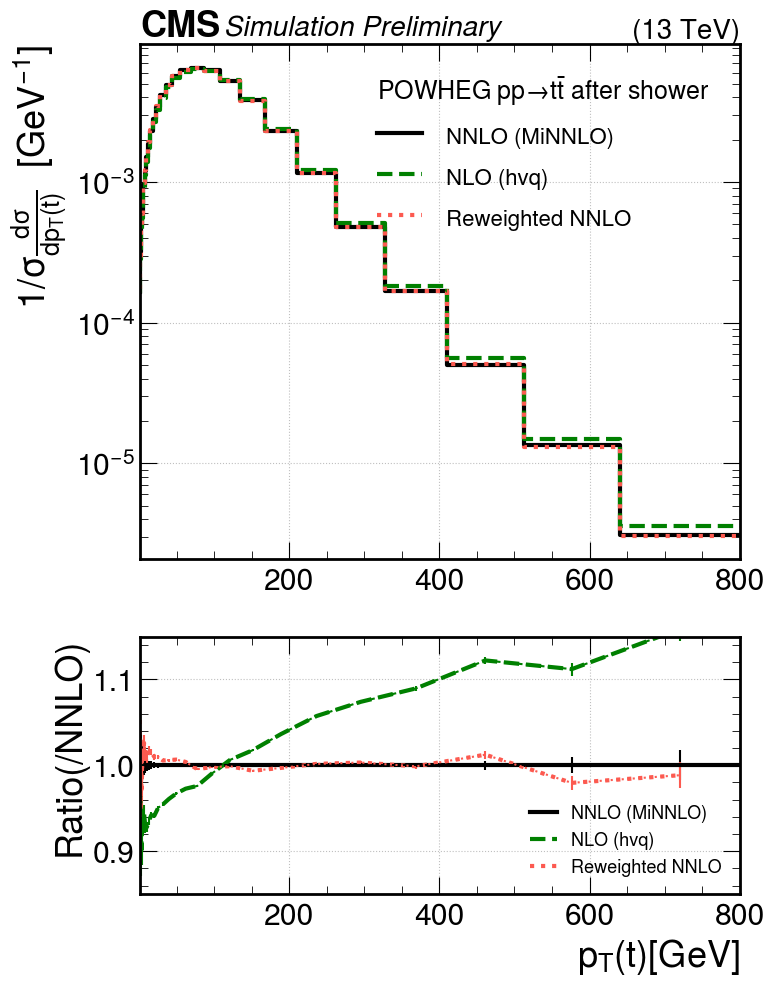

In [11]:
# p_t(t) log binning
log_bins = np.logspace(np.log10(1), np.log10(800), 31)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=1, bins=log_bins, y_scale='log', ratio_ylim=[0.85, 1.15], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_log_0800_31')


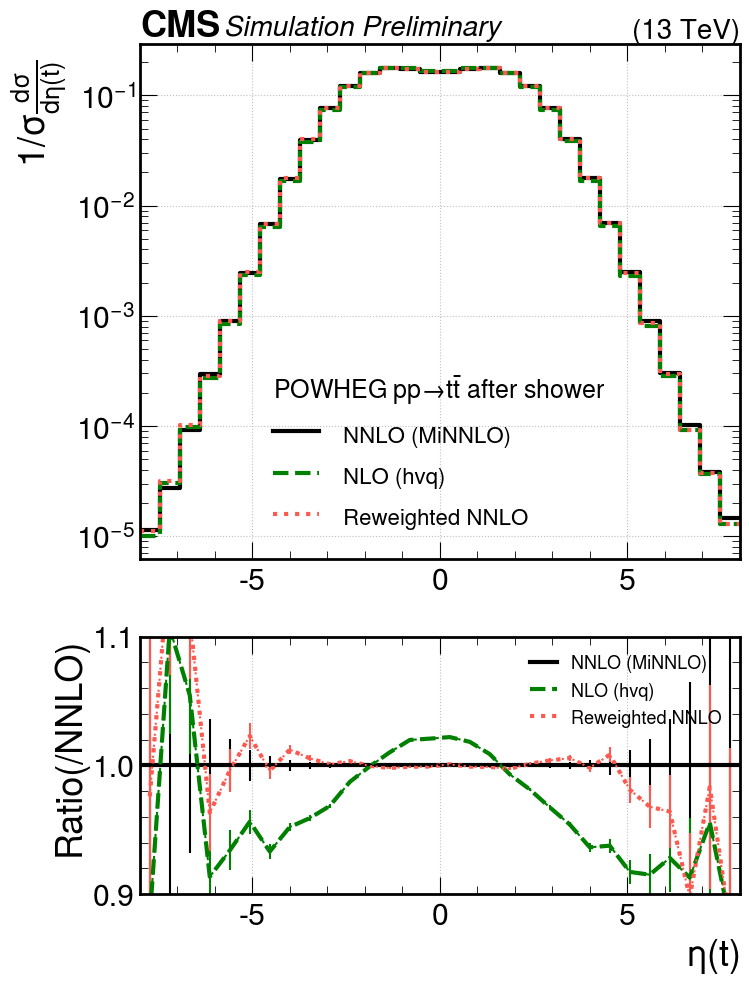

In [12]:
# eta(t) +/- 8
lin_bins = np.linspace(-8, 8, 31)
DCTR.plot_ratio_cms(args, arg_index=4, part_index=1, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_lin_pm8_31')


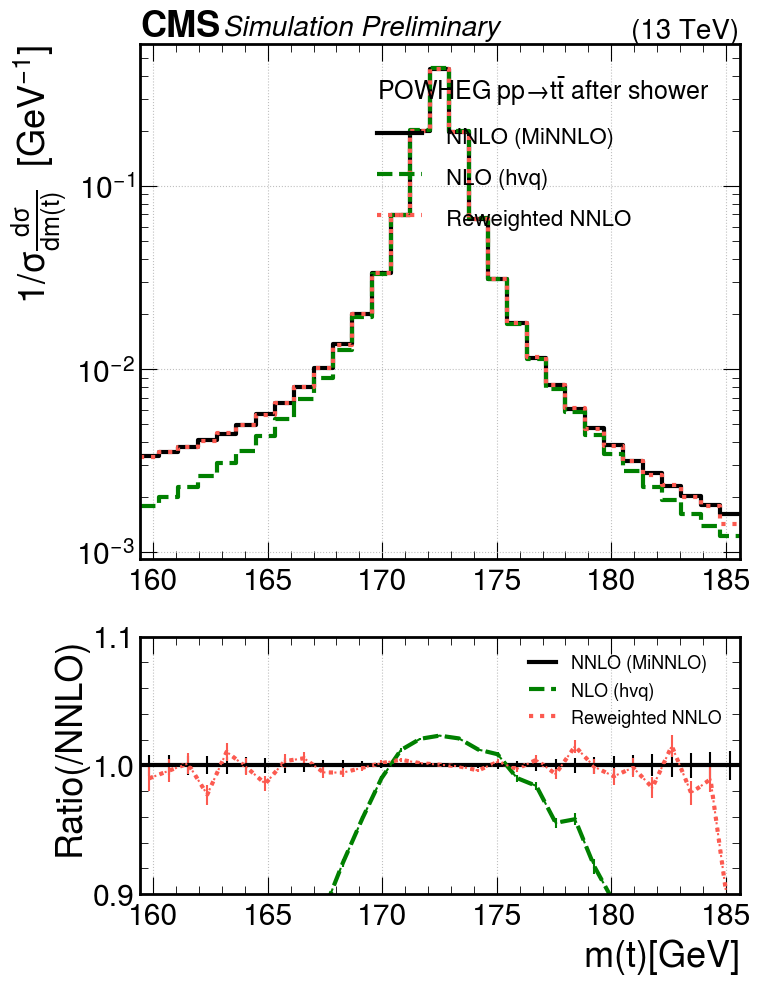

In [13]:
# m(t)

DCTR.plot_ratio_cms(args, arg_index=3, part_index=1, div=32, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_lin_min-max_32')


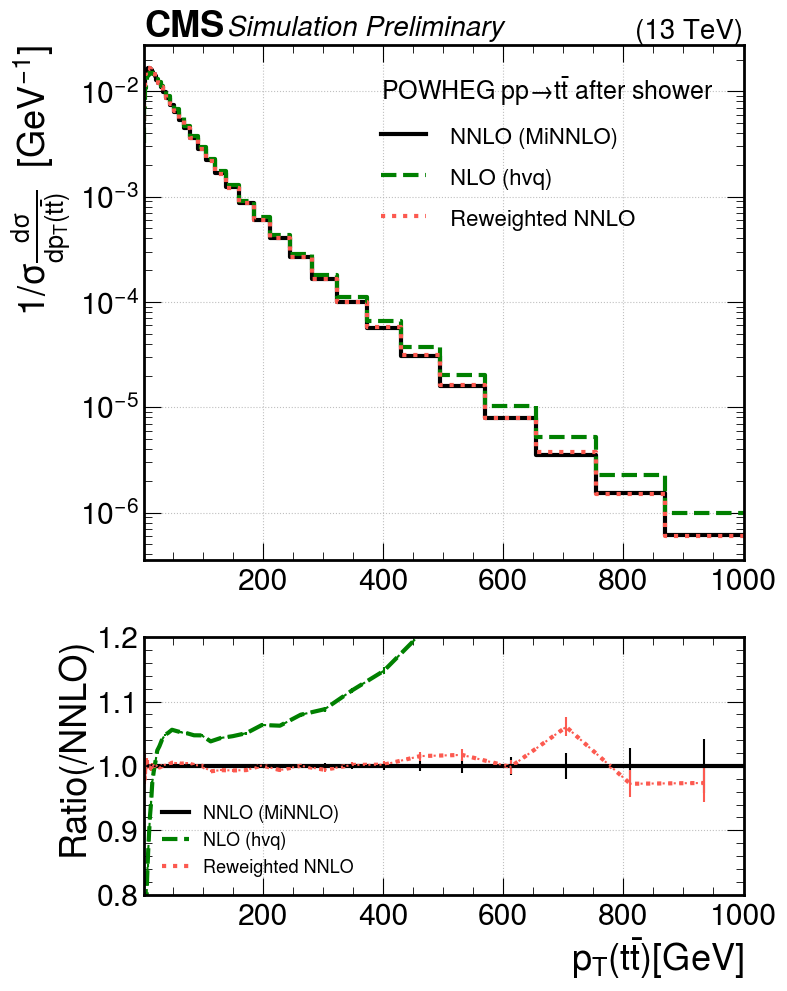

In [14]:
# p_t(tt) log binning
log_bins = np.logspace(np.log10(1), np.log10(1000), 50)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_log_1000_50')


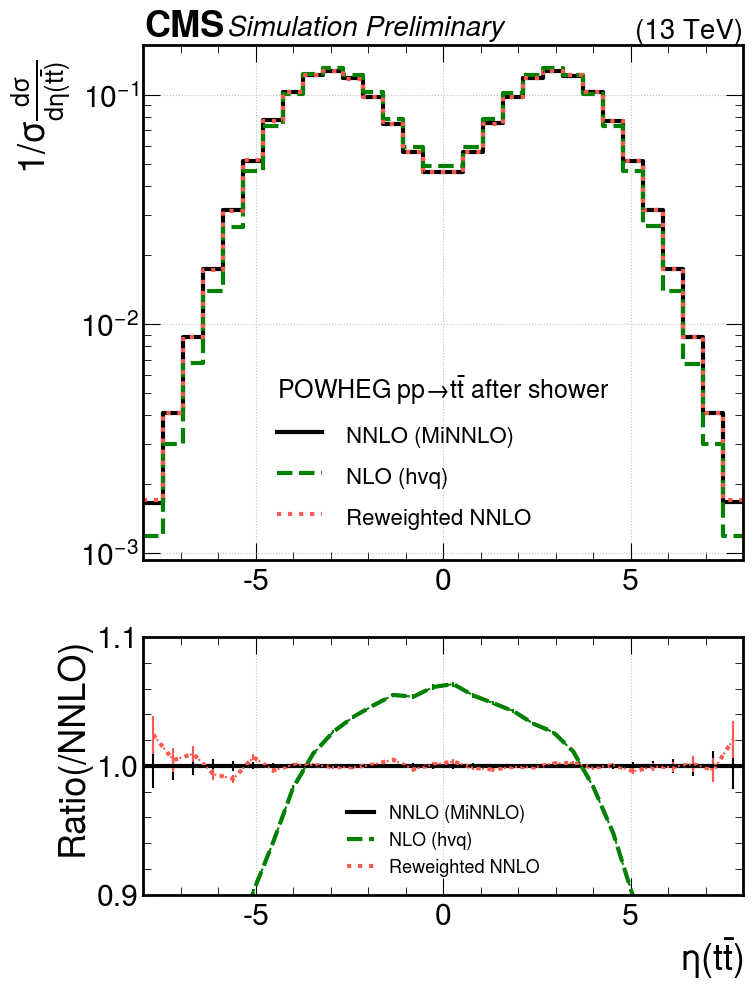

In [15]:
# eta(tt) +/- 8
lin_bins = np.linspace(-8, 8, 31)
DCTR.plot_ratio_cms(args, arg_index=4, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_lin_pm8_31')


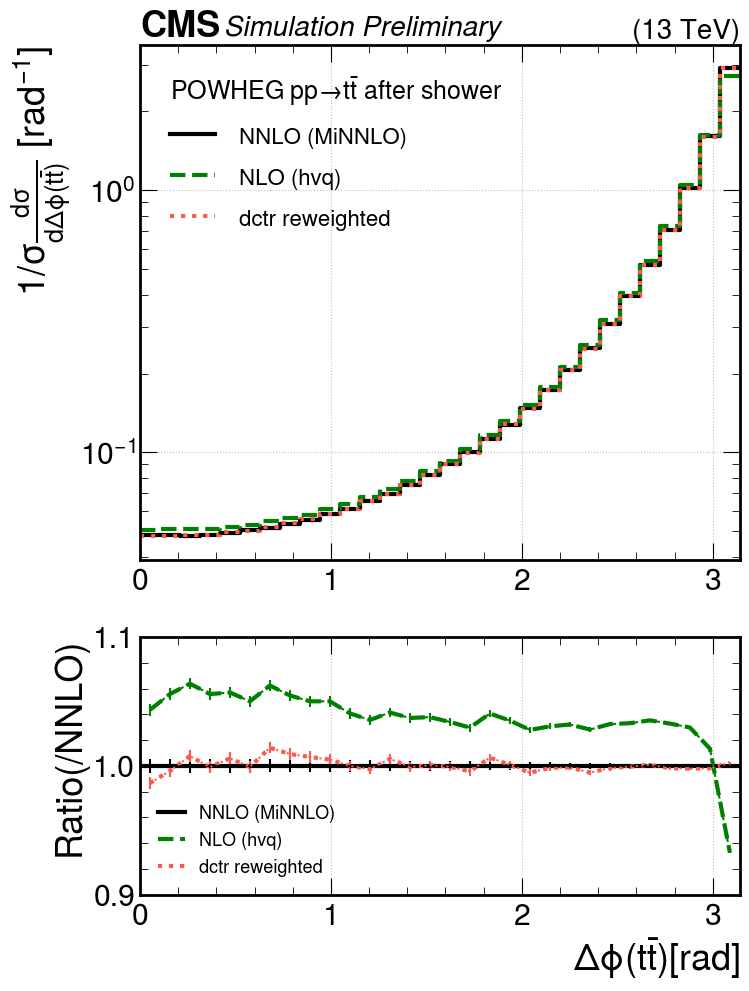

In [16]:
# delta phi
x0_delta_phi = DCTR.delta_phi(x0_plt)
x1_delta_phi = DCTR.delta_phi(x1_plt)

args_delta_phi = [(x1_delta_phi, x1_plt_wgt, 'NNLO (MiNNLO)'), 
                  (x0_delta_phi, x0_plt_wgt, 'NLO (hvq)'),
                  (x0_delta_phi, rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_delta_phi, start = 0, stop = math.pi, div=31, part_label=r't \bar{t}', arg_label=r'\Delta \phi', unit='[rad]', inv_unit='[rad$^{-1}$]', y_scale='log', pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix='showered_lin_pi_31')


In [17]:
# find min values for E and m
min_E_tt = min(x1_plt[:, 0,5]) # min E tt (NNLO)
print(min_E_tt)

min_E_t = min(x1_plt[:, 1,5]) # min E t  (NNLO)
print(min_E_t)

min_m_tt = min(x1_plt[:, 0,3]) # min m tt (NNLO)
print(min_m_tt)


329.56989484655963
0.0
322.91461566907526


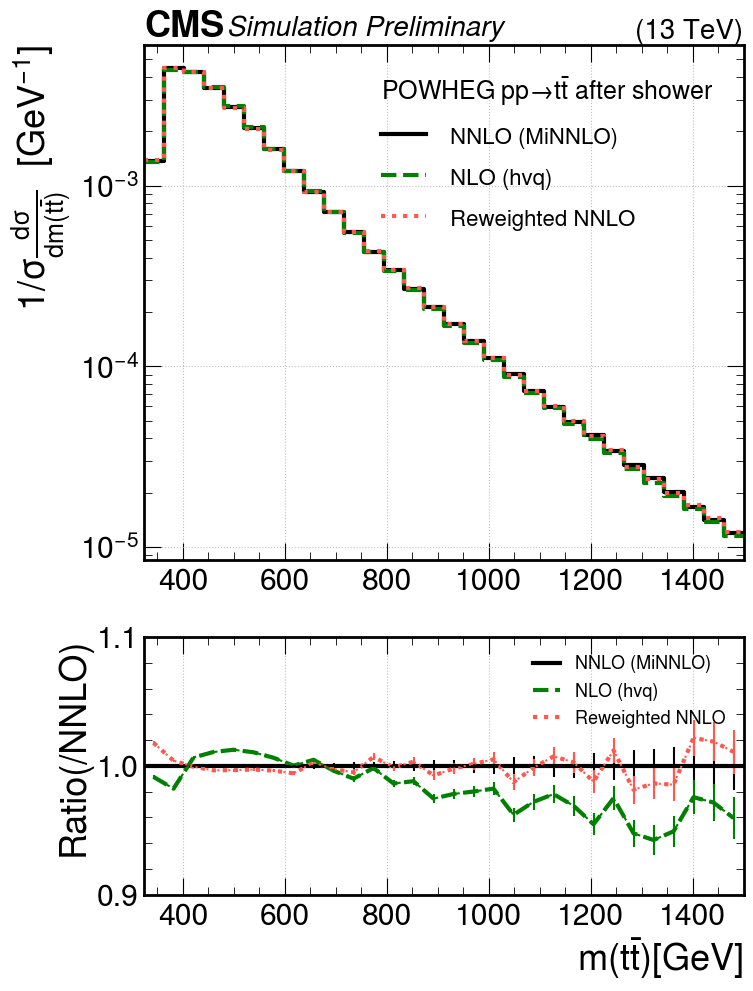

In [18]:
# m(tt) min(X1[:,])
lin_bins = np.linspace(min_m_tt, 1500, 31)
DCTR.plot_ratio_cms(args, arg_index=3, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_lin_min-1500_31')


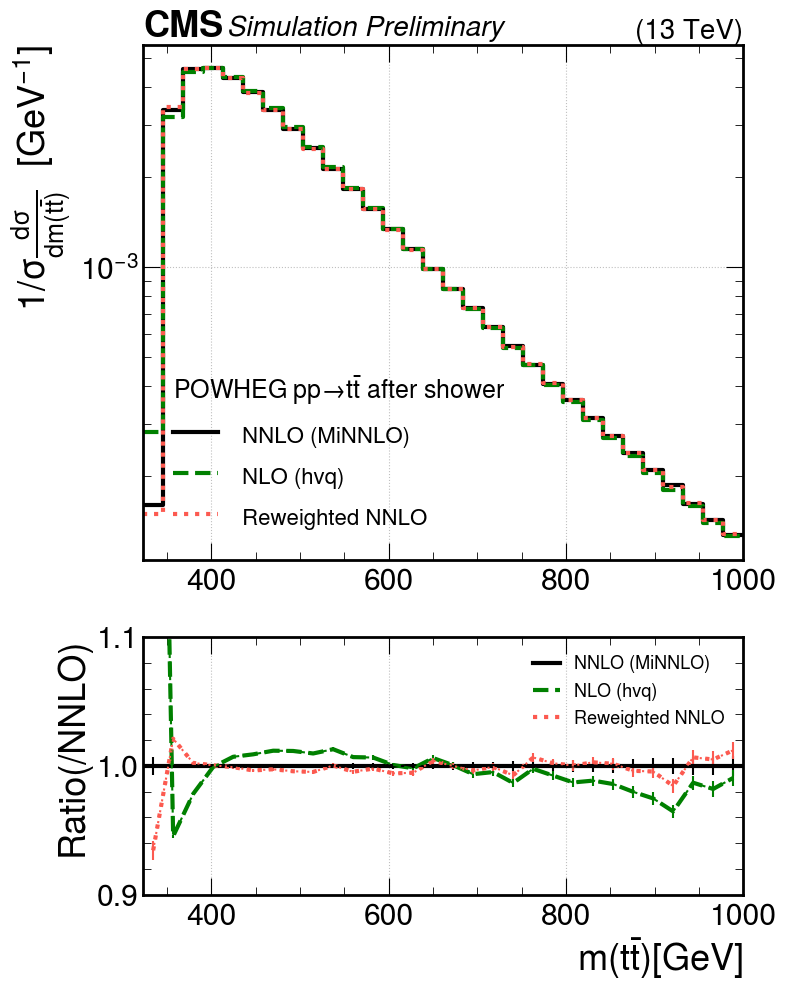

In [19]:
# m(tt) min(X1[:,])
lin_bins = np.linspace(min_m_tt, 1000, 31)
DCTR.plot_ratio_cms(args, arg_index=3, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_lin_min-1000_31')


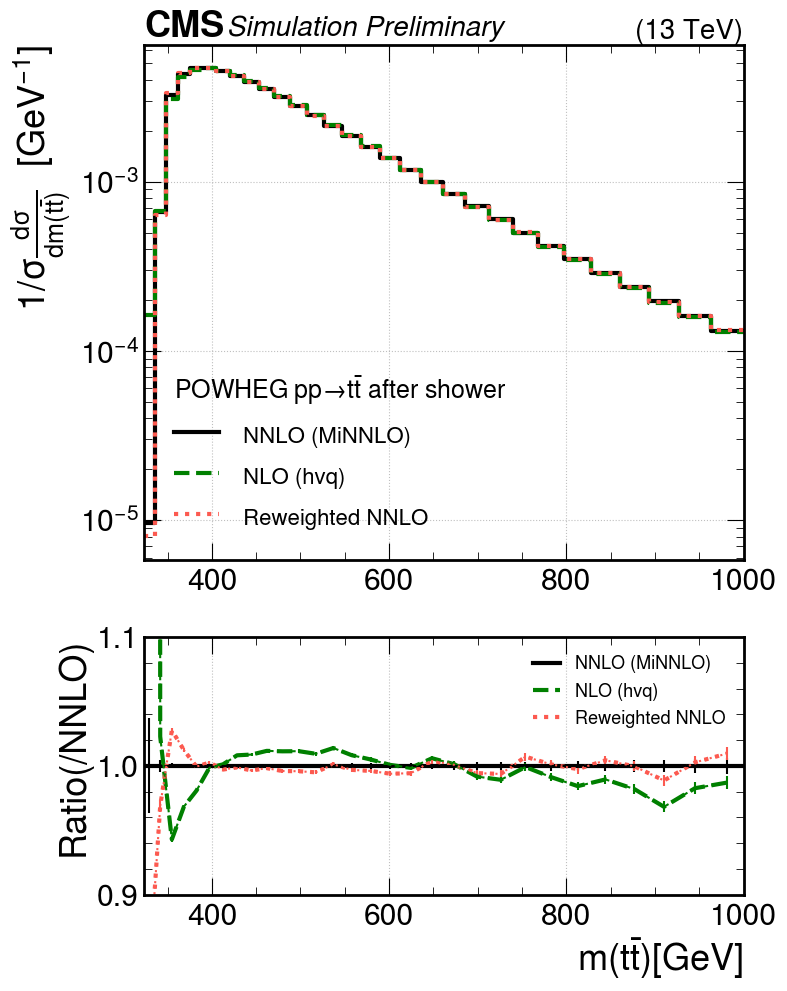

In [20]:
# m(tt) min(X1[:,])
log_bins = np.logspace(np.log10(min_m_tt), np.log10(1000), 31)
DCTR.plot_ratio_cms(args, arg_index=3, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_log_min-1000_31')


# bin rwgt

In [21]:
# different testing plotting data; different from training (01) and regular plotting (02) data; for calculating bin rwgt histograms
x0_plt_test = []
x0_plt_test = np.load(f'{data_dir}/POWHEG_hvq/showered/converted_lhe_03.npy')[:9543943]
print(f'POWHEG hvq x0_plt_test.shape:     {x0_plt_test.shape}')

x0_plt_test_wgt = x0_plt_test[:,0,7].copy()


POWHEG hvq x0_plt_test.shape:     (9543943, 3, 9)


In [ ]:
# every event has particles: 
    # tt-pair, top, anti-top
    # 0      , 1  , 2
# every particle has arguments: 
    # [pt, y, phi, mass, eta, E, PID, w, theta]
    # [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

### with m(tt) and pt(t)

In [47]:
# 2D bin reweighting
bins_m  = np.linspace(0, 2000, 21) # x
bins_pt = np.linspace(0, 1000, 21) # y

# x: m(tt)[:,0,3], y: pt(t)[:,1,0]
hist0_2d, _, _ = np.histogram2d(x = x0_plt_test[:,0,3], y = x0_plt_test[:,1,0], bins = [bins_m, bins_pt], weights = x0_plt_test_wgt, density=True)
hist1_2d, _, _ = np.histogram2d(x = x1_plt[:,0,3], y = x1_plt[:,1,0], bins = [bins_m, bins_pt], weights = x1_plt_wgt, density=True)

np.set_printoptions(precision = 3)

print(hist0_2d.shape)
print(hist1_2d.shape)
# print(hist0_2d)

# what bin did each NLO sample fall into? (plt plotting data, not the plt_test data used to fill the 2D hist above)
x_indices = np.digitize(x0_plt[:,0,3], bins=bins_m)
y_indices = np.digitize(x0_plt[:,1,0], bins=bins_pt)

print(x_indices.shape)
print(y_indices.shape)

# get rwgt as ratio between hist0_2d and hist1_2d
bin_rwgt = []
for i, x_id in enumerate(x_indices):
    y_id = y_indices[i]

    if x_id >= len(bins_m) or y_id >= len(bins_pt): # event outside of hist to the right
        rwgt_ = 1.0
    elif x_id == 0 or y_id == 0: # event outside of hist to the left
        rwgt_ = 1.0
    else:
        if hist0_2d[x_id-1][y_id-1] == 0.0: # avoid divide by zero
            rwgt_ = 1.0
        else:
            rwgt_ = np.divide(hist1_2d[x_id-1][y_id-1], hist0_2d[x_id-1][y_id-1]) # index 1 is first bin is hist[0]
    
    bin_rwgt.append(rwgt_)

bin_rwgt = np.array(bin_rwgt)

print(bin_rwgt.shape)
print(bin_rwgt)

# multiply with generator weights
bin_rwgt = bin_rwgt * x0_plt_wgt


(20, 20)
(20, 20)
(9543943,)
(9543943,)
(9543943,)
[1.011 1.013 1.065 ... 1.011 1.011 1.008]


In [48]:
print(x1_plt_wgt.shape)
print(x0_plt_wgt.shape)
print(rwgt.shape)
print(bin_rwgt.shape)


(9543943,)
(9543943,)
(9543943,)
(9543943,)


In [49]:
# setup args for plotting
args = [(x1_plt, x1_plt_wgt, 'NNLO (MiNNLO)'),
        (x0_plt, x0_plt_wgt, 'NLO (hvq)'),
        (x0_plt, rwgt,       'DCTR Reweighted NNLO'),
        (x0_plt, bin_rwgt,   '2D Bin Reweighted NNLO')]



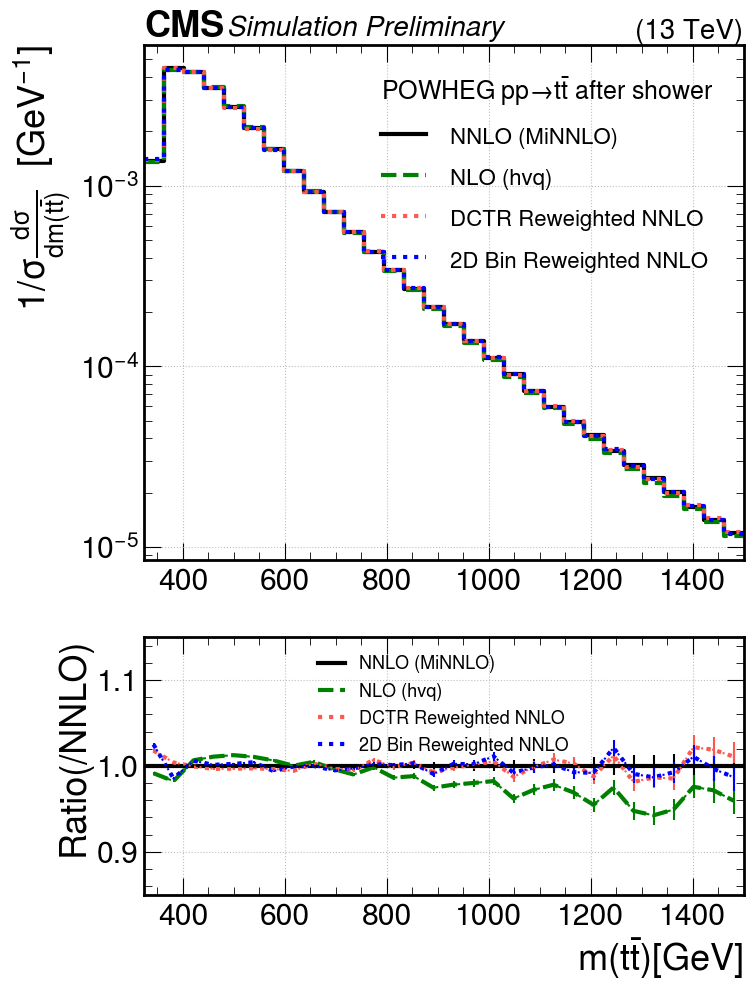

In [50]:
# m(tt) min(X1[:,])
lin_bins = np.linspace(min_m_tt, 1500, 31)
log_bins = np.logspace(np.log10(min_m_tt), np.log10(1500), 31)

DCTR.plot_ratio_cms_4(args, arg_index=3, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.85, 1.15], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_m-tt_pt-t')


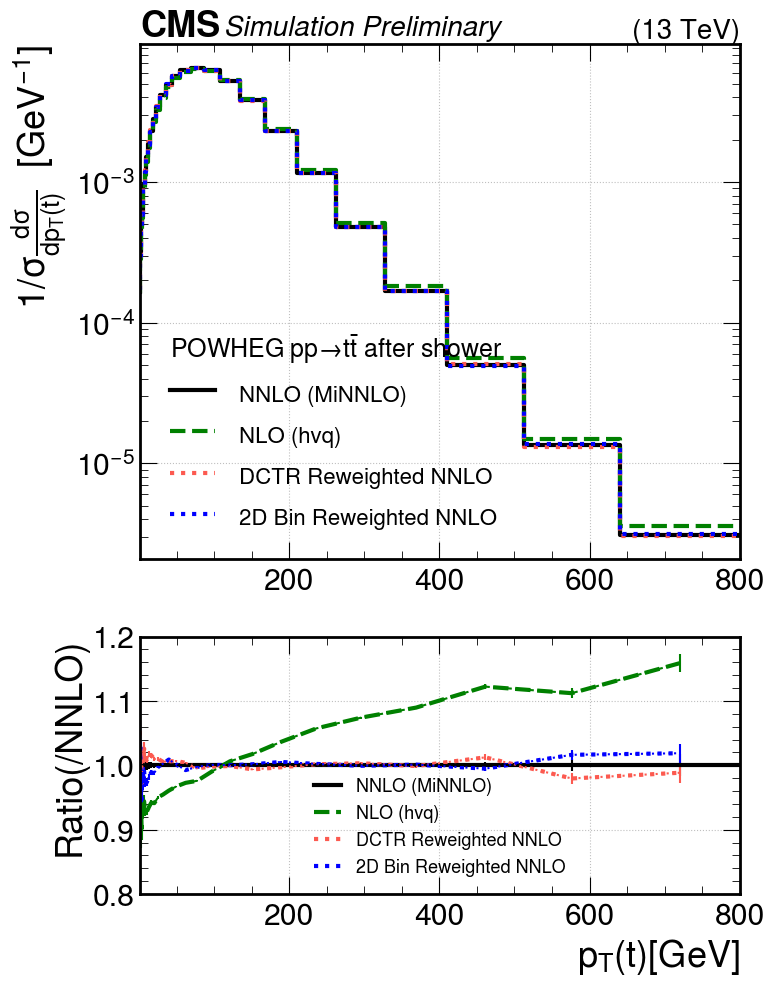

In [51]:
# p_t(t) log binning
log_bins = np.logspace(np.log10(1), np.log10(800), 31)
DCTR.plot_ratio_cms_4(args, arg_index=0, part_index=1, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_m-tt_pt-t')


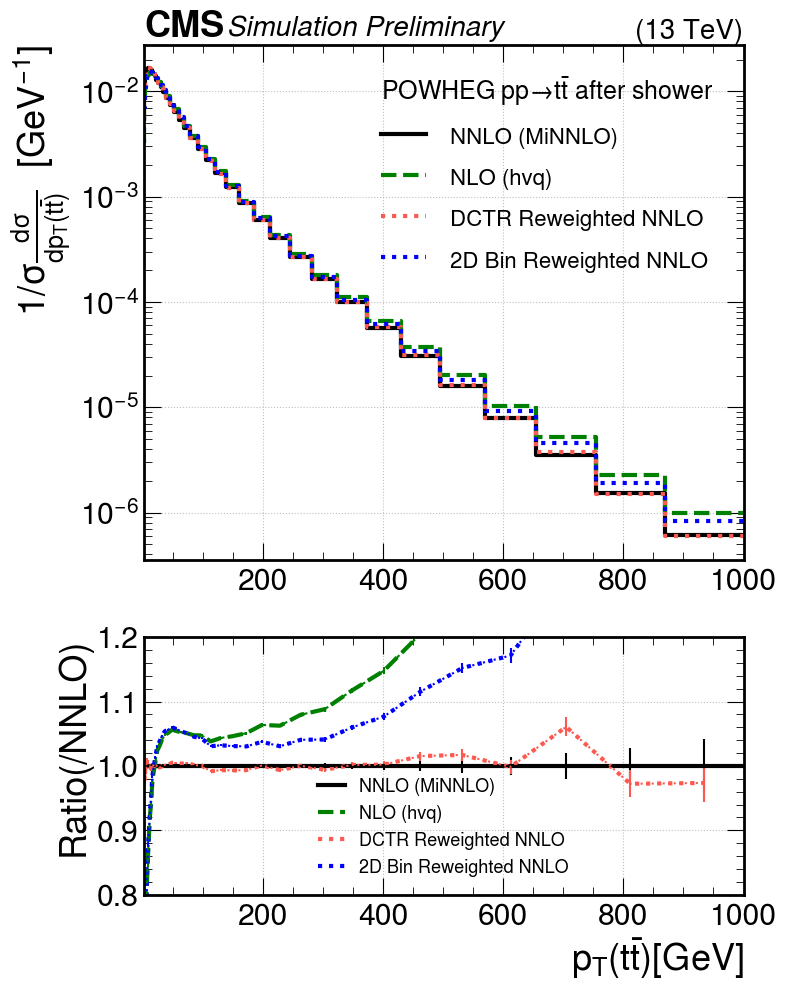

In [52]:
# p_t(tt) log binning
log_bins = np.logspace(np.log10(1), np.log10(1000), 50)
DCTR.plot_ratio_cms_4(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_m-tt_pt-t')


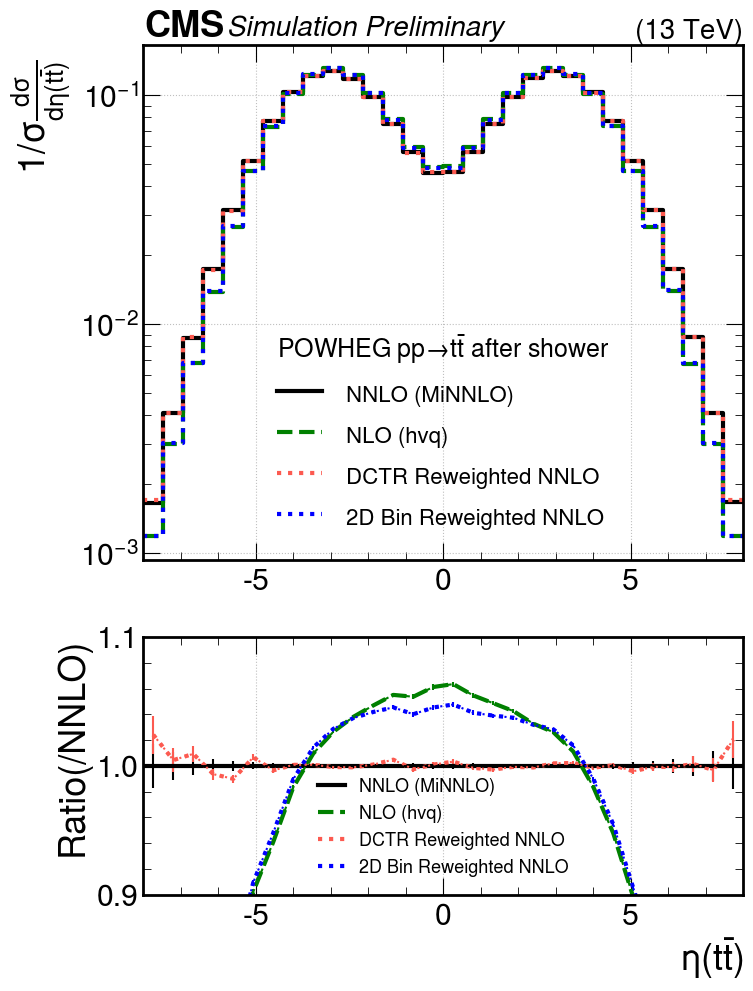

In [53]:
# eta(tt)
lin_bins = np.linspace(-8, 8, 31)
DCTR.plot_ratio_cms_4(args, arg_index=4, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_m-tt_pt-t')


### with pt(tt) and eta(tt)

In [61]:
# 2D bin reweighting
bins_pt  = np.logspace(np.log10(1), np.log10(1500), 21) # x
bins_eta = np.linspace(-9, 9, 21) # y

# x: pt(tt)[:,0,0], y: eta(tt)[:,0,4]
hist0_2d, _, _ = np.histogram2d(x = x0_plt_test[:,0,0], y = x0_plt_test[:,0,4], bins = [bins_pt, bins_eta], weights = x0_plt_test_wgt, density=True)
hist1_2d, _, _ = np.histogram2d(x = x1_plt[:,0,0], y = x1_plt[:,0,4], bins = [bins_pt, bins_eta], weights = x1_plt_wgt, density=True)

np.set_printoptions(precision = 3)

print(hist0_2d.shape)
print(hist1_2d.shape)
# print(hist0_2d)

# what bin did each NLO sample fall into? (plt plotting data, not the plt_test data used to fill the 2D hist above)
x_indices = np.digitize(x0_plt[:,0,0], bins=bins_pt)
y_indices = np.digitize(x0_plt[:,0,4], bins=bins_eta)

print(x_indices.shape)
print(y_indices.shape)

# get rwgt as ratio between hist0_2d and hist1_2d
bin_rwgt = []
for i, x_id in enumerate(x_indices):
    y_id = y_indices[i]

    if x_id >= len(bins_pt) or y_id >= len(bins_eta): # event outside of hist to the right
        rwgt_ = 1.0
    elif x_id == 0 or y_id == 0: # event outside of hist to the left
        rwgt_ = 1.0
    else:
        if hist0_2d[x_id-1][y_id-1] == 0.0: # avoid divide by zero
            rwgt_ = 1.0
        else:
            rwgt_ = np.divide(hist1_2d[x_id-1][y_id-1], hist0_2d[x_id-1][y_id-1]) # index 1 is first bin is hist[0]
    
    bin_rwgt.append(rwgt_)

bin_rwgt = np.array(bin_rwgt)

print(bin_rwgt.shape)
print(bin_rwgt)

# multiply with generator weights
bin_rwgt = bin_rwgt * x0_plt_wgt


(20, 20)
(20, 20)
(9543943,)
(9543943,)
(9543943,)
[0.981 0.946 1.198 ... 0.968 0.986 0.957]


In [62]:
print(x1_plt_wgt.shape)
print(x0_plt_wgt.shape)
print(rwgt.shape)
print(bin_rwgt.shape)


(9543943,)
(9543943,)
(9543943,)
(9543943,)


In [63]:
# setup args for plotting
args = [(x1_plt, x1_plt_wgt, 'NNLO (MiNNLO)'),
        (x0_plt, x0_plt_wgt, 'NLO (hvq)'),
        (x0_plt, rwgt,       'DCTR Reweighted NNLO'),
        (x0_plt, bin_rwgt,   '2D Bin Reweighted NNLO')]



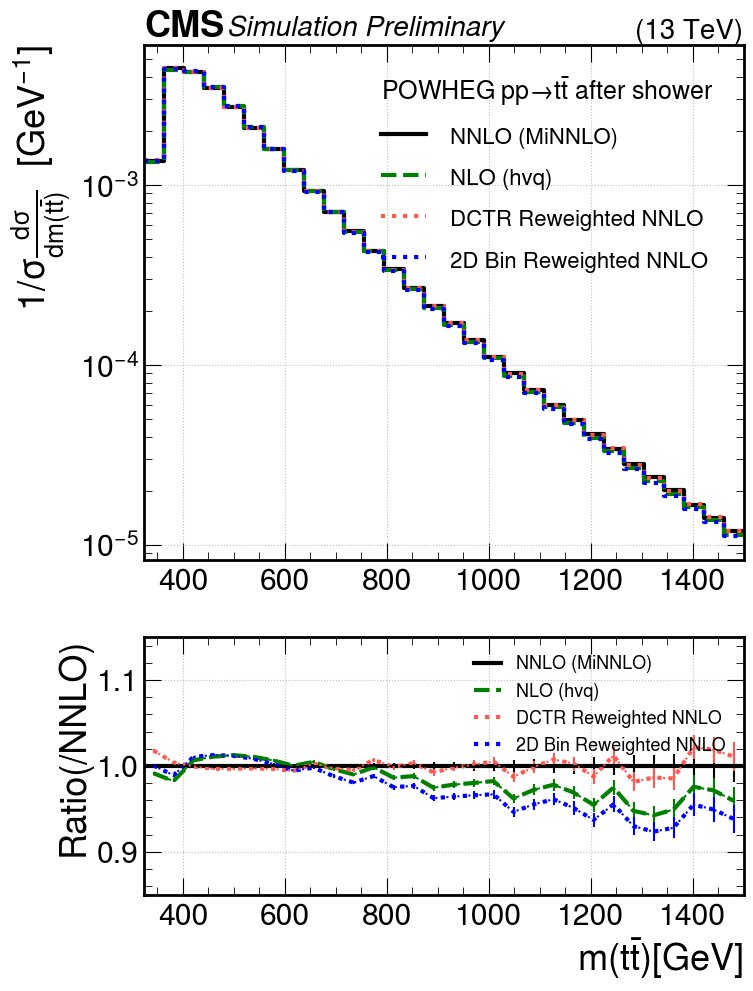

In [64]:
# m(tt) min(X1[:,])
lin_bins = np.linspace(min_m_tt, 1500, 31)

DCTR.plot_ratio_cms_4(args, arg_index=3, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.85, 1.15], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_pt-tt_eta-tt')


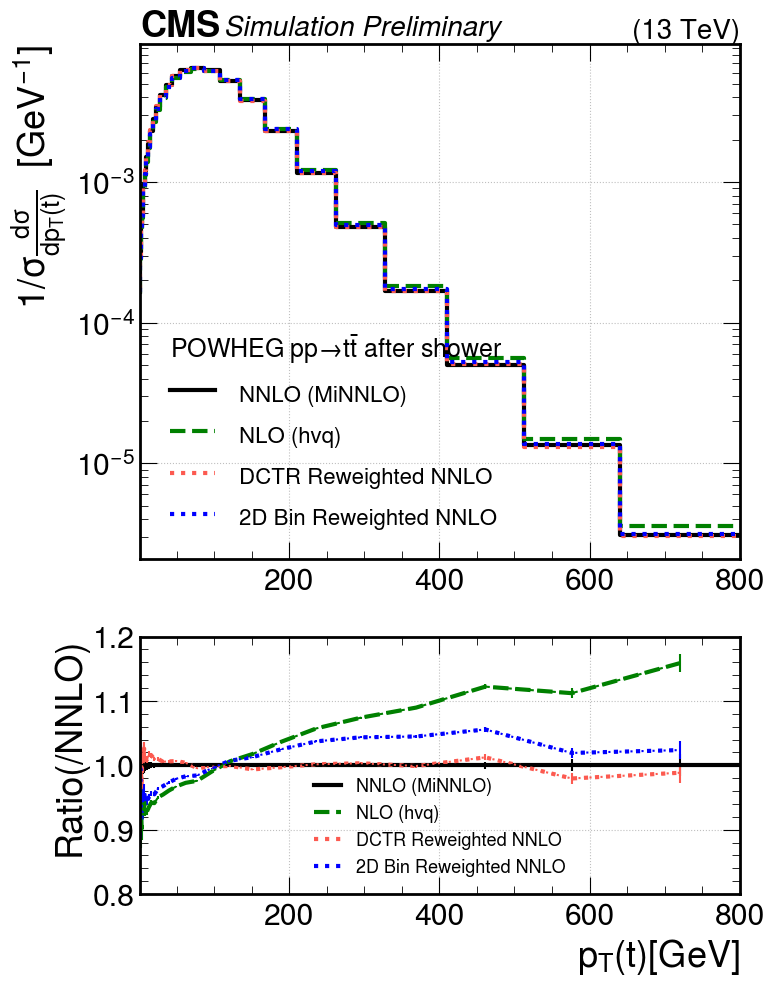

In [65]:
# p_t(t) log binning
log_bins = np.logspace(np.log10(1), np.log10(800), 31)
DCTR.plot_ratio_cms_4(args, arg_index=0, part_index=1, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_pt-tt_eta-tt')


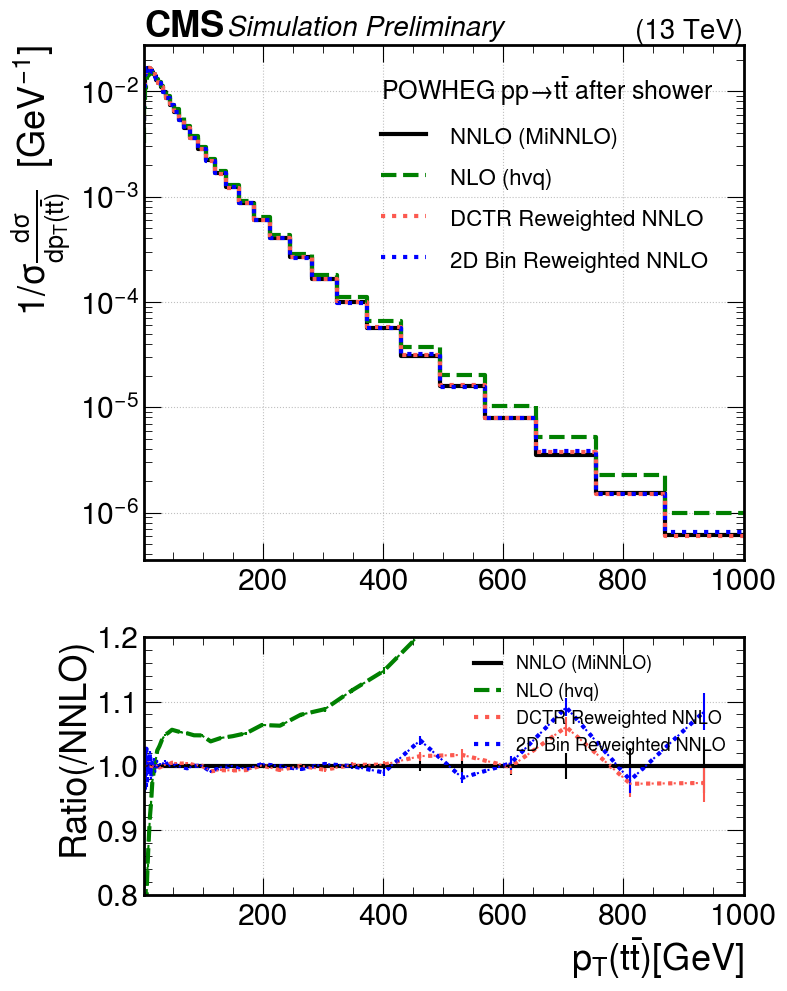

In [69]:
# p_t(tt) log binning
log_bins = np.logspace(np.log10(1), np.log10(1000), 50)
DCTR.plot_ratio_cms_4(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_pt-tt_eta-tt')


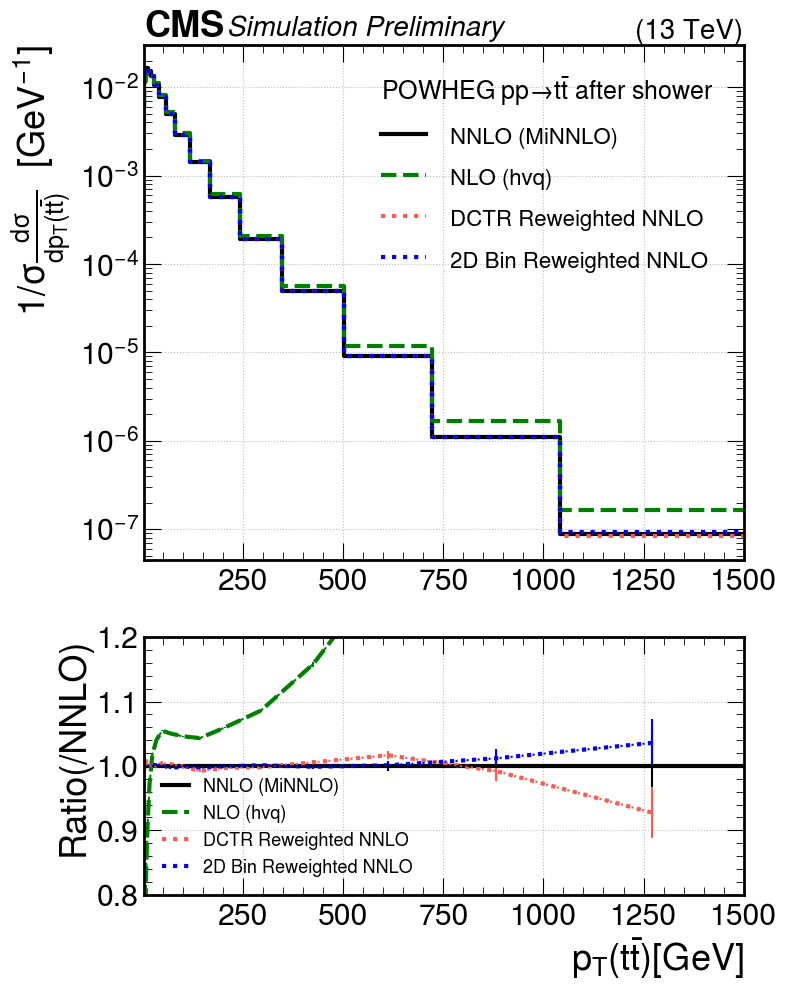

In [70]:
# p_t(tt) same log binning as bin reweighter
log_bins = bins_pt
DCTR.plot_ratio_cms_4(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_pt-tt_eta-tt_same_binning')


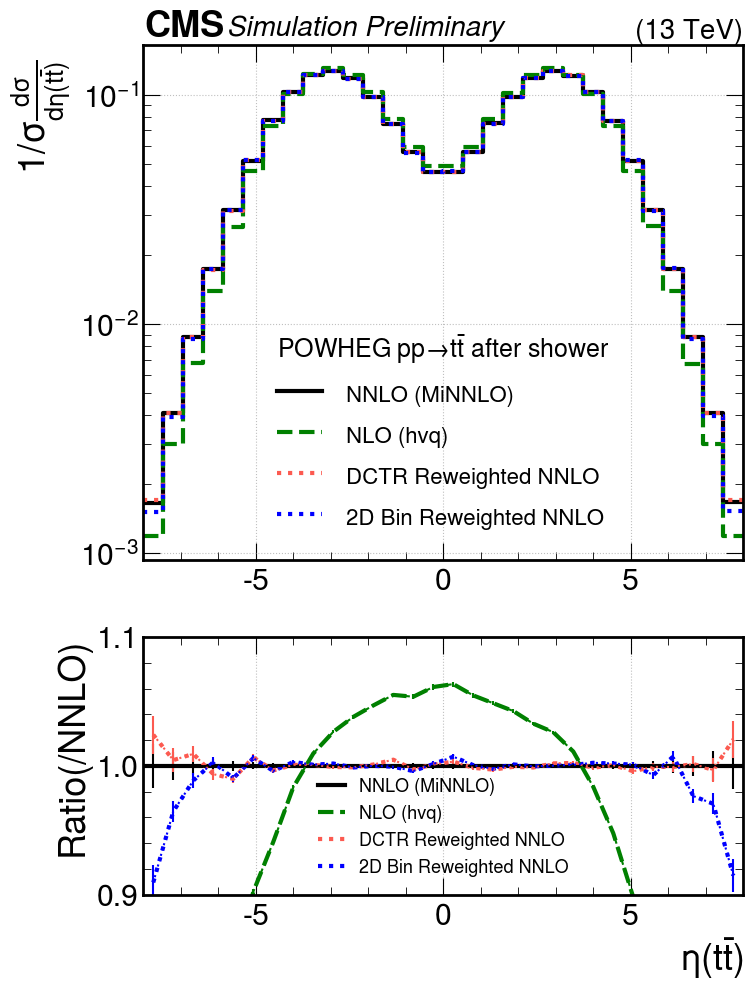

In [67]:
# eta(tt)
lin_bins = np.linspace(-8, 8, 31)
DCTR.plot_ratio_cms_4(args, arg_index=4, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_pt-tt_eta-tt')


In [71]:
# 2D bin reweighting
bins_pt  = np.logspace(np.log10(1), np.log10(1500), 21) # x
bins_eta = np.linspace(-9, 9, 21) # y

# x: pt(tt)[:,0,0], y: eta(tt)[:,0,4]
hist0_2d, _, _ = np.histogram2d(x = x0_plt[:,0,0], y = x0_plt[:,0,4], bins = [bins_pt, bins_eta], weights = x0_plt_wgt, density=True)
hist1_2d, _, _ = np.histogram2d(x = x1_plt[:,0,0], y = x1_plt[:,0,4], bins = [bins_pt, bins_eta], weights = x1_plt_wgt, density=True)

np.set_printoptions(precision = 3)

print(hist0_2d.shape)
print(hist1_2d.shape)
# print(hist0_2d)

# what bin did each NLO sample fall into? (plt plotting data, not the plt_test data used to fill the 2D hist above)
x_indices = np.digitize(x0_plt[:,0,0], bins=bins_pt)
y_indices = np.digitize(x0_plt[:,0,4], bins=bins_eta)

print(x_indices.shape)
print(y_indices.shape)

# get rwgt as ratio between hist0_2d and hist1_2d
bin_rwgt = []
for i, x_id in enumerate(x_indices):
    y_id = y_indices[i]

    if x_id >= len(bins_pt) or y_id >= len(bins_eta): # event outside of hist to the right
        rwgt_ = 1.0
    elif x_id == 0 or y_id == 0: # event outside of hist to the left
        rwgt_ = 1.0
    else:
        if hist0_2d[x_id-1][y_id-1] == 0.0: # avoid divide by zero
            rwgt_ = 1.0
        else:
            rwgt_ = np.divide(hist1_2d[x_id-1][y_id-1], hist0_2d[x_id-1][y_id-1]) # index 1 is first bin is hist[0]
    
    bin_rwgt.append(rwgt_)

bin_rwgt = np.array(bin_rwgt)

print(bin_rwgt.shape)
print(bin_rwgt)

# multiply with generator weights
bin_rwgt = bin_rwgt * x0_plt_wgt


(20, 20)
(20, 20)
(9543943,)
(9543943,)
(9543943,)
[0.984 0.943 1.204 ... 0.973 0.98  0.953]


In [72]:
print(x1_plt_wgt.shape)
print(x0_plt_wgt.shape)
print(rwgt.shape)
print(bin_rwgt.shape)


(9543943,)
(9543943,)
(9543943,)
(9543943,)


In [73]:
# setup args for plotting
args = [(x1_plt, x1_plt_wgt, 'NNLO (MiNNLO)'),
        (x0_plt, x0_plt_wgt, 'NLO (hvq)'),
        (x0_plt, rwgt,       'DCTR Reweighted NNLO'),
        (x0_plt, bin_rwgt,   '2D Bin Reweighted NNLO')]



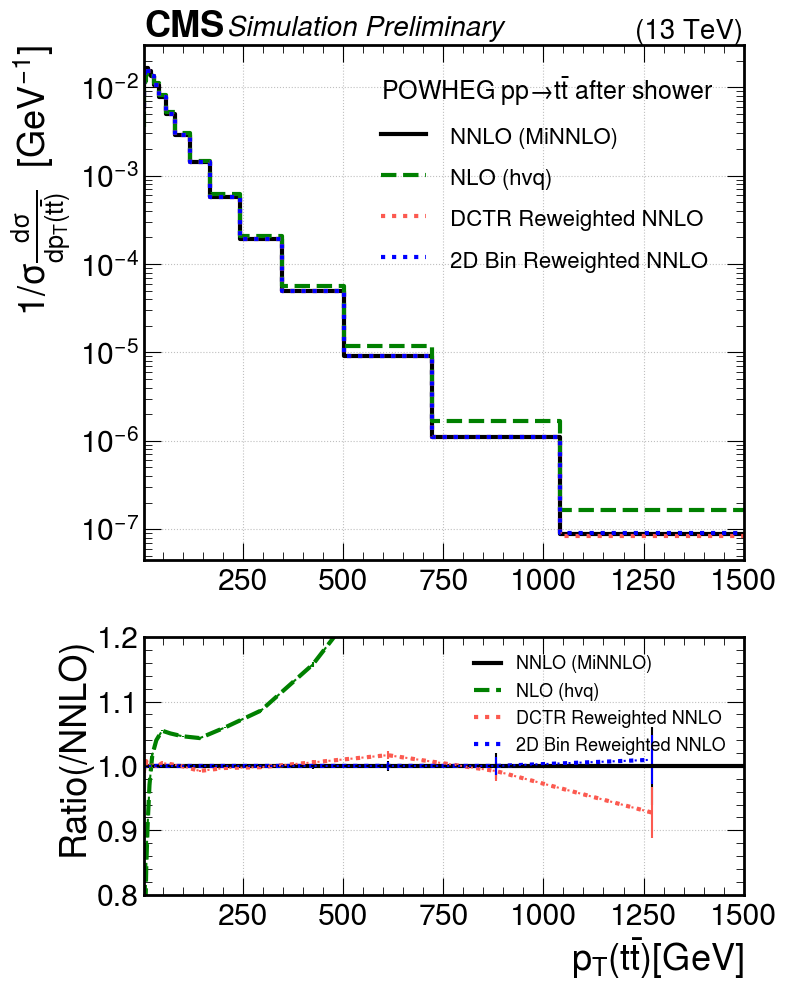

In [74]:
# p_t(tt) log binning
log_bins = bins_pt
DCTR.plot_ratio_cms_4(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'bin_reweighter_pt-tt_eta-tt_same_sample_and_binning')
